<a href="https://colab.research.google.com/github/wangechi01-a/Swahili-News-Classification/blob/main/Swahili_news_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first command installs the inflect package, which is a library for singularizing and pluralizing words, converting numbers to words, and other related linguistic transformations.
The second command installs the pynvml package, which is a Python library for interfacing with NVIDIA Management Library (NVML). NVML is used to monitor and manage various states of NVIDIA GPUs

In [1]:
!pip install inflect
!pip install pynvml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install huggingface_hub["fastai"] -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.8 MB/s eta 0:00:00


In [3]:
! git clone https://github.com/ohmeow/blurr.git

Cloning into 'blurr'...
remote: Enumerating objects: 5397, done.
remote: Counting objects: 100% (1228/1228), done.
remote: Compressing objects: 100% (363/363), done.
remote: Total 5397 (delta 898), reused 1138 (delta 838), pack-reused 4169
Receiving objects: 100% (5397/5397), 36.37 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (4127/4127), done.


In [4]:
%cd /content/blurr

/content/blurr


In [5]:
!pip install -e ".[dev]" -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import the necessary libraries

In [6]:
import torch
import numpy as np
import pandas as pd
import random
import gc
import transformers
from fastai.text.all import *
import inflect
import pynvml


from blurr.text.data.all import *
from blurr.text.modeling.all import *
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

The repository for squad contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/squad.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [7]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("mbeukman/xlm-roberta-base-finetuned-swahili-finetuned-ner-swahili")
model = AutoModelForTokenClassification.from_pretrained("mbeukman/xlm-roberta-base-finetuned-swahili-finetuned-ner-swahili")

tokenizer_config.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [8]:
class CFG :
  path = "/content/drive/MyDrive/Colab Notebooks/Ml_Swahili"
  project_name = 'Swahili_News_Classification_Challenge'
  model = "mbeukman/xlm-roberta-base-finetuned-swahili-finetuned-ner-swahili"

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  seed = 2023
  train_name = 'Train.csv'
  test_name = 'Test.csv'
  label_mappings = None
  batch_size = 8
  max_length = 512
  num_classes = 5
  dropout = 0.0
  num_epochs = 4
  learning_rate = 2e-5
  weight_decay = 1e-2
  model_cls = transformers.AutoModelForSequenceClassification
  n_splits = 4

In [9]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [10]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False

In [11]:
random_seed(CFG.seed,True)

In [12]:
import fastai
fastai.__version__

'2.7.15'

# Loading the Datasets

In [13]:
train = pd.read_csv(CFG.path + '/' + CFG.train_name)
test = pd.read_csv(CFG.path + '/' + CFG.test_name)

In [14]:
train.head()

,id,content,category
0,SW0,"SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa na Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Yussuf Masauni wakati akifungua semina ya siku mbili iliyofanyika jijini Dar es Salaam ikiwahusisha viongozi wa taasisi za Kiislamu, lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zao.Naibu Waziri amesema mwelekeo na malengo ya Serikali ya Awamu ya Tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananc...",Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesitisha likizo za viongozi wote mkoani humo kutekeleza maazimio ya Jukwaa la Fursa za Biashara la mkoa huo.Mwanri ameagiza kuwa, hata kama kuna likizo zimeidhinishwa zifutwe.Amemuagiza Katibu Tawala wa Mkoa huo, Msalika Makungu kuandika barua kwa viongozi kuhusu uamuzi huo na amebainisha kuwa hakushauriwa na mtu, kaamua yeye.“Anayebisha anyooshe mkono, ajifanye angalau anajikuna tu” amesema Mwanri kwenye jukwaa hilo la nane lililomalizika leo.Amewaeleza viongozi wa Tabora kuwa, mambo waliyopanga kuyafanya wakati wa likizo nje ya Tabora wanaweza kuy...",Biashara
2,SW10,"SERIKALI imetoa miezi sita kwa taasisi zote za umma ambazo hazitumii mfumo wa GePG katika ukusanyaji wa fedha kufanya hivyo na baada ya hapo itafanya ukaguzi na kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo.Akifungua mkutano wa mwaka wa kwanza wa watumiaji wa mfumo huo jana jijini hapa, Naibu Katibu Mkuu Wizara ya Fedha na Mipango, Dk Hartibu Kazungu alisema ukaguzi huo ambao utaanza kufanyika Juni mwakani baada ya kipindi kilichowekwa kupita ili kuwabaini maofisa wazembe.Alisema, wizara yake itafanya ukaguzi wa ofisi zote za umma ili kubaini kama kuna fedha zinazokusanywa ...",Kitaifa
3,SW100,"KAMPUNI ya mchezo wa kubahatisha ya M-bet imeingia makubaliano ya udhamini na timu ya soka ya Manispaa ya Kinondoni (KMC) kwa miaka mitano wenye thamani ya sh Bilioni 1.Akizungumzia udhamini huo jana baada ya kusaini mkataba huo, Meneja Masoko wa Mbet, Allen Mushi alisema sababu ya kuiunga mkono timu hiyo ni baada ya kuvutiwa na kiwango bora walichokionesha timu hiyo tangu msimu uliopita. Alisema kitendo cha kumaliza ligi katika nafasi ya nne bora sio cha mchezo na kwamba hata wanapokuwa uwanjani hucheza soka la kuvutia tofauti na wengine.“Tumeichagua KMC kwasababu tumevutiwa na mambo men...",michezo
4,SW1000,"WATANZANIA wamekumbushwa kusherehekea sikukuu ya Krismasi kwa kuenzi amani, umoja na kulinda tamaduni za nchi ili kupambana na changamoto mbalimbali zinazojitokeza, ikiwemo vitendo vya ushoga na matumizi ya dawa za kulevya.Akizungumza wakati wa kutoa heri ya sikukuu hiyo ya Kuzaliwa Yesu Kristo, Kiongozi wa Waislamu wa madhehebu ya Shia Ithnasheriya, Shehe Hemed Jalala alisema kuzaliwa kwa Yesu kunalenga kuhubiri na kutangaza amani ulimwenguni. Shehe Jalala alisema licha ya Wayahudi kutilia shaka kuzaliwa kwa Yesu, lakini pindi alipozaliwa alitangaza amani kwake na duniani kote akitaka ki...",Kitaifa


In [15]:
test.head()

,swahili_id,content
0,ae3baa6c34aa523fd2aa4de3c89448efff922311,"Rais John Magufuli amemuagiza Msajili wa Hazina Athumani Mbuttuka kuhakikisha kuwa mashirika yote nchini ambayo yamekuwa hayatoi gawio kwa serikali, yanafanya hivyo ifikapo Julai mwaka huu. Ameyasema hayo mapema leo, Jumanne, alipokuwa akizungumza katika hafla ya kupokea gawio la serikali kutoka shirika la simu la TTCL lililofanyika kwenye makao makuu ya shirika hilo, jijini Dar es Salaam. Rais Magufuli amesema yapo mashirika 253 nchini ambayo huwa hayatoi gawio kwa kigezo cha kuwa yanajiendesha kwa hasara, jambo alilosema wachague kulirekebisha na kuanza kutoa gawio au yafungwe.“Msajili ..."
1,c4ee26a3ade8064a2ec494996e836900fd32dd8e,"TAHARUKI imezuka katika mkutano wa Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Masauni na wananchi wa Wilaya ya Njombe baada ya kusikika milipuko ya mabomu ya machozi jirani na mkutano huo, hali iliyowafanya wananchi kukimbia hovyo na wengine kuelekea kwenye tukio.Masauni yuko mkoani Njombe kufuatilia matukio ya mauaji ya watoto yanayoendelea mkoani humo, ambapo mpaka sasa watoto wapatao 10 wameripotiwa kuuawa katika mazingira ya kutatanisha, yanayohusishwa na imani za kishirikina.Akiwa katika mkutano huo na wananchi kwenye Uwanja wa Turbo wilayani humo, ghafla ilisikika milipuko ya mab..."
2,58aee3aa1d94554ff57e6a053dbd60658e4890ff,"KOCHA wa Azam FC ya Dar es Salaam, Idd Cheche amesema anajipanga kurudisha ubora wa kikosi hicho ili kufanya vizuri katika michezo yote iliyoko mbele yake.Cheche alizungumza hayo juzi baada ya kupata ushindi wa kwanza wa ligi ikiwa ni siku chache tangu akabidhiwe kikosi hicho baada ya kutimuliwa kwa makocha Hans Pluijm na Msaidizi wake Juma Mwambusi.Azam FC ilishinda mabao 3-1 dhidi ya African Lyon katika mchezo uliochezwa ugenini juzi kwenye uwanja wa Uhuru, Dar es Salaam.“Tunataka kuirudisha Azam FC tuliyoizoea kama ile ya zamani ili kuwapa ladha wadau na mashabiki wa soka nchini, bado ..."
3,00579c2307b5c11003d21c40c3ecff5e922c3fd8,"THAMANI ya mauzo ya bidhaa za Afrika Mashariki katika Umoja wa Ulaya (EU) yameongezeka hadi Dola za Marekani bilioni 2.5 (Sh trilioni 5.2 za Tanzania) mwaka 2017, sawa na ongezeko la asilimia nane.Taarifa hiyo ni kwa mujibu wa Kituo cha Biashara cha Kimataifa (ITC).Kwa mujibu wa ITC, bidhaa kutoka ukanda huo zilizouzwa Ulaya kwa mwaka 2016 zilikuwa na thamani ya Dola milioni 2.3 (Sh trilioni 4.83 za Tanzania), hivyo kumekuwa na ongezeko la takribani Sh bilioni 400. Mkurugenzi wa Sekta ya Uzalishaji ya EAC, Jean Baptiste, amesema hivi karibuni jijini Arusha yalipo makao makuu ya jumuiya hi..."
4,c83e9738ae5d1790ee85b99863deb734e7614c52,"WAZIRI wa Nchi, Ofi si ya Makamu wa Rais, Muungano na Mazingira, Januari Makamba amesema Watanzania wengi watapata kipato kwa kutengeneza, kuuza na kusambaza mifuko mbadala baada ya zuio la matumizi ya mifuko ya plastiki kuanzia Juni mosi, mwaka huu.Alisema mbali ya kipato hatua hiyo pia itawezesha wafanyabiashara na wawekezaji wa ndani ya nchi kuanzisha viwanda vidogo vya kutengeneza mifuko mbadala, hatua itakayokuza uchumi na kuzalisha ajira.Aliyasema hayo juzi alipokutana na kufanya mazungumzo na watendaji wa taasisi mbalimbali za Jiji la Dar es Salaam. Alisema zaidi ya nchi 60 tayari ..."


In [16]:
train.shape, test.shape

((5151, 3), (1030, 2))

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5151 non-null   object
 1   content   5151 non-null   object
 2   category  5151 non-null   object
dtypes: object(3)
memory usage: 120.9+ KB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   swahili_id  1030 non-null   object
 1   content     1030 non-null   object
dtypes: object(2)
memory usage: 16.2+ KB


In [19]:
def preprocess(df, text_col, target_col= None,id_col= None ):
    # Rename columns if necessary
    if text_col != 'inputs':
        df.rename(columns={text_col: 'inputs'}, inplace=True)
    if target_col:
        if target_col != 'target':
            df.rename(columns={target_col: 'label'}, inplace=True)
    if id_col:
        if id_col != 'id':
            df.rename(columns={id_col: 'id'}, inplace=True)


    df['Character Count'] = df['inputs'].apply(lambda x: len(str(x)))

    return df



train = preprocess(df=train,text_col='content',target_col='category',id_col='swahili_id')
test = preprocess(df=test,text_col='content',target_col='category',id_col='swahili_id')

In [20]:
train.head()

,id,inputs,label,Character Count
0,SW0,"SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa na Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Yussuf Masauni wakati akifungua semina ya siku mbili iliyofanyika jijini Dar es Salaam ikiwahusisha viongozi wa taasisi za Kiislamu, lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zao.Naibu Waziri amesema mwelekeo na malengo ya Serikali ya Awamu ya Tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananc...",Kitaifa,1584
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesitisha likizo za viongozi wote mkoani humo kutekeleza maazimio ya Jukwaa la Fursa za Biashara la mkoa huo.Mwanri ameagiza kuwa, hata kama kuna likizo zimeidhinishwa zifutwe.Amemuagiza Katibu Tawala wa Mkoa huo, Msalika Makungu kuandika barua kwa viongozi kuhusu uamuzi huo na amebainisha kuwa hakushauriwa na mtu, kaamua yeye.“Anayebisha anyooshe mkono, ajifanye angalau anajikuna tu” amesema Mwanri kwenye jukwaa hilo la nane lililomalizika leo.Amewaeleza viongozi wa Tabora kuwa, mambo waliyopanga kuyafanya wakati wa likizo nje ya Tabora wanaweza kuy...",Biashara,1317
2,SW10,"SERIKALI imetoa miezi sita kwa taasisi zote za umma ambazo hazitumii mfumo wa GePG katika ukusanyaji wa fedha kufanya hivyo na baada ya hapo itafanya ukaguzi na kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo.Akifungua mkutano wa mwaka wa kwanza wa watumiaji wa mfumo huo jana jijini hapa, Naibu Katibu Mkuu Wizara ya Fedha na Mipango, Dk Hartibu Kazungu alisema ukaguzi huo ambao utaanza kufanyika Juni mwakani baada ya kipindi kilichowekwa kupita ili kuwabaini maofisa wazembe.Alisema, wizara yake itafanya ukaguzi wa ofisi zote za umma ili kubaini kama kuna fedha zinazokusanywa ...",Kitaifa,2610
3,SW100,"KAMPUNI ya mchezo wa kubahatisha ya M-bet imeingia makubaliano ya udhamini na timu ya soka ya Manispaa ya Kinondoni (KMC) kwa miaka mitano wenye thamani ya sh Bilioni 1.Akizungumzia udhamini huo jana baada ya kusaini mkataba huo, Meneja Masoko wa Mbet, Allen Mushi alisema sababu ya kuiunga mkono timu hiyo ni baada ya kuvutiwa na kiwango bora walichokionesha timu hiyo tangu msimu uliopita. Alisema kitendo cha kumaliza ligi katika nafasi ya nne bora sio cha mchezo na kwamba hata wanapokuwa uwanjani hucheza soka la kuvutia tofauti na wengine.“Tumeichagua KMC kwasababu tumevutiwa na mambo men...",michezo,1404
4,SW1000,"WATANZANIA wamekumbushwa kusherehekea sikukuu ya Krismasi kwa kuenzi amani, umoja na kulinda tamaduni za nchi ili kupambana na changamoto mbalimbali zinazojitokeza, ikiwemo vitendo vya ushoga na matumizi ya dawa za kulevya.Akizungumza wakati wa kutoa heri ya sikukuu hiyo ya Kuzaliwa Yesu Kristo, Kiongozi wa Waislamu wa madhehebu ya Shia Ithnasheriya, Shehe Hemed Jalala alisema kuzaliwa kwa Yesu kunalenga kuhubiri na kutangaza amani ulimwenguni. Shehe Jalala alisema licha ya Wayahudi kutilia shaka kuzaliwa kwa Yesu, lakini pindi alipozaliwa alitangaza amani kwake na duniani kote akitaka ki...",Kitaifa,2247


In [21]:
test.head()

,id,inputs,Character Count
0,ae3baa6c34aa523fd2aa4de3c89448efff922311,"Rais John Magufuli amemuagiza Msajili wa Hazina Athumani Mbuttuka kuhakikisha kuwa mashirika yote nchini ambayo yamekuwa hayatoi gawio kwa serikali, yanafanya hivyo ifikapo Julai mwaka huu. Ameyasema hayo mapema leo, Jumanne, alipokuwa akizungumza katika hafla ya kupokea gawio la serikali kutoka shirika la simu la TTCL lililofanyika kwenye makao makuu ya shirika hilo, jijini Dar es Salaam. Rais Magufuli amesema yapo mashirika 253 nchini ambayo huwa hayatoi gawio kwa kigezo cha kuwa yanajiendesha kwa hasara, jambo alilosema wachague kulirekebisha na kuanza kutoa gawio au yafungwe.“Msajili ...",1215
1,c4ee26a3ade8064a2ec494996e836900fd32dd8e,"TAHARUKI imezuka katika mkutano wa Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Masauni na wananchi wa Wilaya ya Njombe baada ya kusikika milipuko ya mabomu ya machozi jirani na mkutano huo, hali iliyowafanya wananchi kukimbia hovyo na wengine kuelekea kwenye tukio.Masauni yuko mkoani Njombe kufuatilia matukio ya mauaji ya watoto yanayoendelea mkoani humo, ambapo mpaka sasa watoto wapatao 10 wameripotiwa kuuawa katika mazingira ya kutatanisha, yanayohusishwa na imani za kishirikina.Akiwa katika mkutano huo na wananchi kwenye Uwanja wa Turbo wilayani humo, ghafla ilisikika milipuko ya mab...",4408
2,58aee3aa1d94554ff57e6a053dbd60658e4890ff,"KOCHA wa Azam FC ya Dar es Salaam, Idd Cheche amesema anajipanga kurudisha ubora wa kikosi hicho ili kufanya vizuri katika michezo yote iliyoko mbele yake.Cheche alizungumza hayo juzi baada ya kupata ushindi wa kwanza wa ligi ikiwa ni siku chache tangu akabidhiwe kikosi hicho baada ya kutimuliwa kwa makocha Hans Pluijm na Msaidizi wake Juma Mwambusi.Azam FC ilishinda mabao 3-1 dhidi ya African Lyon katika mchezo uliochezwa ugenini juzi kwenye uwanja wa Uhuru, Dar es Salaam.“Tunataka kuirudisha Azam FC tuliyoizoea kama ile ya zamani ili kuwapa ladha wadau na mashabiki wa soka nchini, bado ...",1548
3,00579c2307b5c11003d21c40c3ecff5e922c3fd8,"THAMANI ya mauzo ya bidhaa za Afrika Mashariki katika Umoja wa Ulaya (EU) yameongezeka hadi Dola za Marekani bilioni 2.5 (Sh trilioni 5.2 za Tanzania) mwaka 2017, sawa na ongezeko la asilimia nane.Taarifa hiyo ni kwa mujibu wa Kituo cha Biashara cha Kimataifa (ITC).Kwa mujibu wa ITC, bidhaa kutoka ukanda huo zilizouzwa Ulaya kwa mwaka 2016 zilikuwa na thamani ya Dola milioni 2.3 (Sh trilioni 4.83 za Tanzania), hivyo kumekuwa na ongezeko la takribani Sh bilioni 400. Mkurugenzi wa Sekta ya Uzalishaji ya EAC, Jean Baptiste, amesema hivi karibuni jijini Arusha yalipo makao makuu ya jumuiya hi...",1339
4,c83e9738ae5d1790ee85b99863deb734e7614c52,"WAZIRI wa Nchi, Ofi si ya Makamu wa Rais, Muungano na Mazingira, Januari Makamba amesema Watanzania wengi watapata kipato kwa kutengeneza, kuuza na kusambaza mifuko mbadala baada ya zuio la matumizi ya mifuko ya plastiki kuanzia Juni mosi, mwaka huu.Alisema mbali ya kipato hatua hiyo pia itawezesha wafanyabiashara na wawekezaji wa ndani ya nchi kuanzisha viwanda vidogo vya kutengeneza mifuko mbadala, hatua itakayokuza uchumi na kuzalisha ajira.Aliyasema hayo juzi alipokutana na kufanya mazungumzo na watendaji wa taasisi mbalimbali za Jiji la Dar es Salaam. Alisema zaidi ya nchi 60 tayari ...",1626


In [22]:
train.rename(columns={'target': 'label'}, inplace=True)
train = train[['inputs','label']]
train = train.dropna()

train.head()

,inputs,label
0,"SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa na Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Yussuf Masauni wakati akifungua semina ya siku mbili iliyofanyika jijini Dar es Salaam ikiwahusisha viongozi wa taasisi za Kiislamu, lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zao.Naibu Waziri amesema mwelekeo na malengo ya Serikali ya Awamu ya Tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananc...",Kitaifa
1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesitisha likizo za viongozi wote mkoani humo kutekeleza maazimio ya Jukwaa la Fursa za Biashara la mkoa huo.Mwanri ameagiza kuwa, hata kama kuna likizo zimeidhinishwa zifutwe.Amemuagiza Katibu Tawala wa Mkoa huo, Msalika Makungu kuandika barua kwa viongozi kuhusu uamuzi huo na amebainisha kuwa hakushauriwa na mtu, kaamua yeye.“Anayebisha anyooshe mkono, ajifanye angalau anajikuna tu” amesema Mwanri kwenye jukwaa hilo la nane lililomalizika leo.Amewaeleza viongozi wa Tabora kuwa, mambo waliyopanga kuyafanya wakati wa likizo nje ya Tabora wanaweza kuy...",Biashara
2,"SERIKALI imetoa miezi sita kwa taasisi zote za umma ambazo hazitumii mfumo wa GePG katika ukusanyaji wa fedha kufanya hivyo na baada ya hapo itafanya ukaguzi na kuwawajibisha maofi sa masuhuli walioshindwa kutekeleza hilo.Akifungua mkutano wa mwaka wa kwanza wa watumiaji wa mfumo huo jana jijini hapa, Naibu Katibu Mkuu Wizara ya Fedha na Mipango, Dk Hartibu Kazungu alisema ukaguzi huo ambao utaanza kufanyika Juni mwakani baada ya kipindi kilichowekwa kupita ili kuwabaini maofisa wazembe.Alisema, wizara yake itafanya ukaguzi wa ofisi zote za umma ili kubaini kama kuna fedha zinazokusanywa ...",Kitaifa
3,"KAMPUNI ya mchezo wa kubahatisha ya M-bet imeingia makubaliano ya udhamini na timu ya soka ya Manispaa ya Kinondoni (KMC) kwa miaka mitano wenye thamani ya sh Bilioni 1.Akizungumzia udhamini huo jana baada ya kusaini mkataba huo, Meneja Masoko wa Mbet, Allen Mushi alisema sababu ya kuiunga mkono timu hiyo ni baada ya kuvutiwa na kiwango bora walichokionesha timu hiyo tangu msimu uliopita. Alisema kitendo cha kumaliza ligi katika nafasi ya nne bora sio cha mchezo na kwamba hata wanapokuwa uwanjani hucheza soka la kuvutia tofauti na wengine.“Tumeichagua KMC kwasababu tumevutiwa na mambo men...",michezo
4,"WATANZANIA wamekumbushwa kusherehekea sikukuu ya Krismasi kwa kuenzi amani, umoja na kulinda tamaduni za nchi ili kupambana na changamoto mbalimbali zinazojitokeza, ikiwemo vitendo vya ushoga na matumizi ya dawa za kulevya.Akizungumza wakati wa kutoa heri ya sikukuu hiyo ya Kuzaliwa Yesu Kristo, Kiongozi wa Waislamu wa madhehebu ya Shia Ithnasheriya, Shehe Hemed Jalala alisema kuzaliwa kwa Yesu kunalenga kuhubiri na kutangaza amani ulimwenguni. Shehe Jalala alisema licha ya Wayahudi kutilia shaka kuzaliwa kwa Yesu, lakini pindi alipozaliwa alitangaza amani kwake na duniani kote akitaka ki...",Kitaifa


In [23]:
train['label'] = le.fit_transform(train['label'])
CFG.label_mappings = dict(zip(le.classes_, le.transform(le.classes_)))
print(CFG.label_mappings)

{'Biashara': 0, 'Burudani': 1, 'Kimataifa': 2, 'Kitaifa': 3, 'michezo': 4}


# Perform Cross Validation

In [24]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle = True , random_state = CFG.seed)


train['fold'] = -1

for fold, (_, test_index) in enumerate(kf.split(train, train['label'])):
    train.loc[test_index, 'fold'] = fold

In [25]:
train['fold'].value_counts()

fold
0    1288
1    1288
2    1288
3    1287
Name: count, dtype: int64

In [26]:
train['label'].value_counts()

label
3    2000
4    1720
0    1360
2      54
1      17
Name: count, dtype: int64

In [27]:
os.makedirs('/content/drive/MyDrive/Lacuna_Masakhane_POS_classification/intfloat', exist_ok=True)

In [28]:
'_'.join(str(lang) for lang in [0])

'0'

epoch,train_loss,valid_loss,accuracy,time
0,1.170639,1.168774,0.388199,06:33
1,1.173804,1.155227,0.388199,06:33
2,1.174150,1.156927,0.388199,06:33
3,1.157828,1.152743,0.388199,06:33


Better model found at epoch 0 with valid_loss value: 1.1687740087509155.
Better model found at epoch 1 with valid_loss value: 1.1552274227142334.
Epoch 2: reducing lr to 1.2011167818922017e-05
Better model found at epoch 3 with valid_loss value: 1.1527434587478638.


Processes before GC:
	GPU:0
process      10654 uses    10166.000 MB GPU memory
Processes after GC:
	GPU:0
process      10654 uses     2426.000 MB GPU memory
1030
Submission file saved: /content/drive/MyDrive/Colab Notebooks/Ml_Swahili/fold_0.csv


epoch,train_loss,valid_loss,accuracy,time
0,0.406756,0.355843,0.871894,06:37
1,0.258737,0.309377,0.894410,06:38
2,0.166567,0.285221,0.905280,06:39
3,0.103971,0.308406,0.911491,06:38


Better model found at epoch 0 with valid_loss value: 0.35584279894828796.
Better model found at epoch 1 with valid_loss value: 0.3093765676021576.
Better model found at epoch 2 with valid_loss value: 0.2852209210395813.
Epoch 2: reducing lr to 1.0954315229743707e-06


Processes before GC:
	GPU:0
process      10654 uses     9766.000 MB GPU memory
Processes after GC:
	GPU:0
process      10654 uses     2478.000 MB GPU memory
1030
Submission file saved: /content/drive/MyDrive/Colab Notebooks/Ml_Swahili/fold_1.csv


epoch,train_loss,valid_loss,accuracy,time
0,0.334493,0.324239,0.887422,06:37
1,0.323662,0.340468,0.867236,06:37
2,0.264875,0.272749,0.902950,06:36
3,0.163904,0.270397,0.902950,06:37


Better model found at epoch 0 with valid_loss value: 0.3242393434047699.
Better model found at epoch 2 with valid_loss value: 0.2727491855621338.
Epoch 2: reducing lr to 2.288680895929934e-06
Better model found at epoch 3 with valid_loss value: 0.2703966796398163.


Processes before GC:
	GPU:0
process      10654 uses     9698.000 MB GPU memory
Processes after GC:
	GPU:0
process      10654 uses     2454.000 MB GPU memory
1030
Submission file saved: /content/drive/MyDrive/Colab Notebooks/Ml_Swahili/fold_2.csv


epoch,train_loss,valid_loss,accuracy,time
0,1.208216,1.164775,0.388500,06:34
1,1.210629,1.152746,0.388500,06:32
2,1.166329,1.161924,0.334110,06:33
3,1.134225,1.149955,0.388500,06:33


Better model found at epoch 0 with valid_loss value: 1.1647746562957764.
Better model found at epoch 1 with valid_loss value: 1.1527457237243652.
Epoch 2: reducing lr to 8.309633467774402e-06
Better model found at epoch 3 with valid_loss value: 1.1499550342559814.


Processes before GC:
	GPU:0
process      10654 uses     9756.000 MB GPU memory
Processes after GC:
	GPU:0
process      10654 uses     2440.000 MB GPU memory
1030
Submission file saved: /content/drive/MyDrive/Colab Notebooks/Ml_Swahili/fold_3.csv


epoch,train_loss,valid_loss,accuracy,time


TypeError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	unsupported operand type(s) for -: 'NoneType' and 'float'

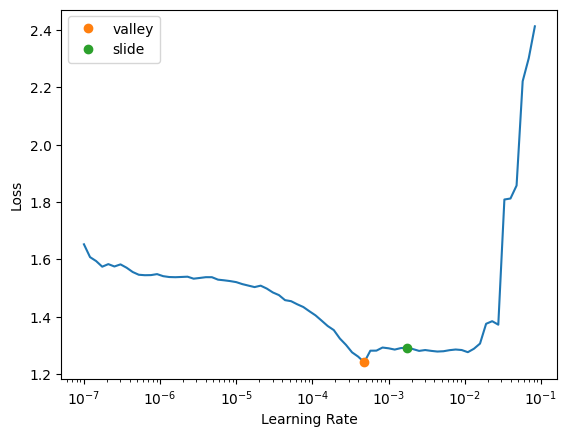

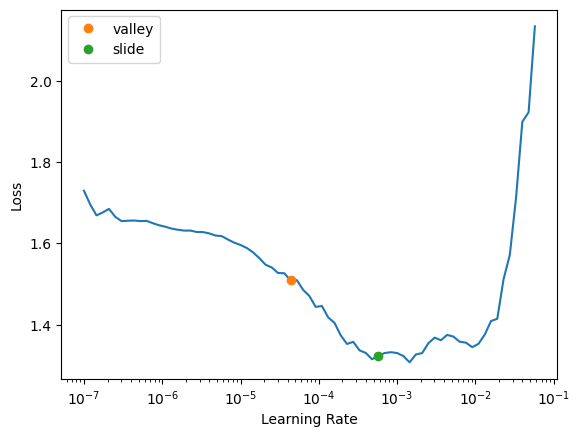

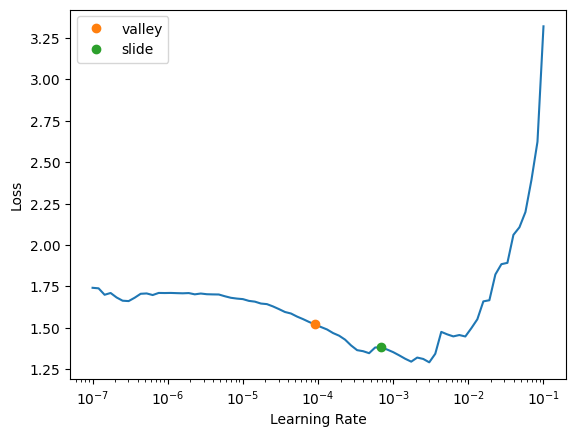

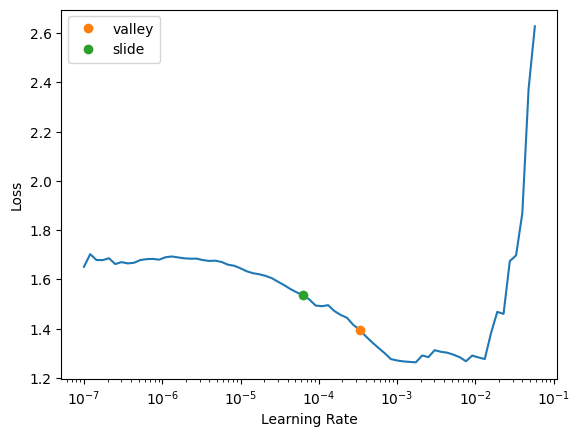

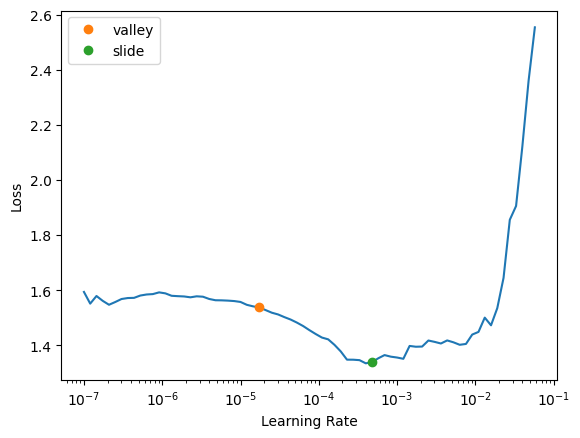

In [29]:
valid_languages = [[0],[1],[2],[3],[4]]

def generate_submission_file(valid_languages, preds, language_names):
    fold_name = '_'.join(str(lang) for lang in language_names)
    submission_file_name = f"fold_{fold_name}.csv"
    submission_file_path = os.path.join(CFG.path, submission_file_name)
    submission = pd.DataFrame()
    submission["id"] = test['id']
    k = np.unique(train.label).tolist()
    for i, c in enumerate(k):
        submission[c] = preds[:, i]
    submission = submission.rename(columns={0: 'Biashara', 1: 'Burudani', 2: 'Kimataifa', 3: 'Kitaifa', 4: 'michezo'})
    submission[['id', "Kitaifa"   ,"michezo"   ,"Biashara"   ,"Kimataifa"   ,"Burudani"]]
    submission.to_csv(submission_file_path, index=False)

    print(f"Submission file saved: {submission_file_path}")




def gc_gpu():
    print(f"Processes before GC:\n\t{torch.cuda.list_gpu_processes()}")
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Processes after GC:\n\t{torch.cuda.list_gpu_processes()}")

def train_with_cross_validation(train, valid_languages, test, fold_idx, fine_tune = False):


    config = transformers.AutoConfig.from_pretrained(CFG.model)
    config.num_labels = CFG.num_classes

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
      CFG.model,
      model_cls=CFG.model_cls,
      config=config
    )


    # The datablock
    train['is_valid'] = train['fold'].isin(valid_languages)
    blocks= (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
        CategoryBlock
         )
    # The datablock
    dblock = DataBlock(
        blocks=blocks,
        get_x=ColReader("inputs"),
        get_y=ColReader("label"),
        splitter=ColSplitter('is_valid')
    )


    # Creating the dataloader
    dls = dblock.dataloaders(train, bs=CFG.batch_size)

    # Creating the model
    model = BaseModelWrapper(hf_model)

    # Creating the learner
    learn = Learner(
        dls,
        hf_model,
        opt_func=partial(Adam, decouple_wd=True),
        loss_func=CrossEntropyLossFlat(),
        metrics=[accuracy],
        cbs=[BaseModelCallback, SaveModelCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2, min_lr=1e-8)],
    )
    if fine_tune:
      _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
      learn.fine_tune(CFG.num_epochs, _valley)
    else:
      learn.freeze()
      _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
      learn.fit_one_cycle(CFG.num_epochs, _valley)


    # Test predictions
    test_dl = learn.dls.test_dl(test['inputs'])
    preds,_ = learn.tta(dl=test_dl, n=5)

    del(learn)
    gc_gpu()
    return preds

preds_list = []
fold_idx=0
for valid_language in valid_languages:
    preds_fold = train_with_cross_validation(train, valid_language, test, fold_idx, fine_tune=False)
    # Generate submission file for the current valid language list
    preds_list.append(preds_fold)
    print(len(preds_fold))
    generate_submission_file(valid_language, preds_fold, valid_language)
    fold_idx += 1


# Calculate mean predictions
preds_mean = torch.stack(preds_list).mean(dim=0)

In [33]:
# Calculate mean predictions
preds_mean = torch.stack(preds_list).mean(dim=0)
preds_mean

tensor([[0.1807, 0.0014, 0.0064, 0.6436, 0.1680],
        [0.1322, 0.0013, 0.0055, 0.6933, 0.1678],
        [0.1316, 0.0013, 0.0051, 0.2113, 0.6507],
        ...,
        [0.6306, 0.0014, 0.0050, 0.1968, 0.1662],
        [0.1316, 0.0013, 0.0051, 0.2131, 0.6488],
        [0.1316, 0.0013, 0.0051, 0.2173, 0.6447]])

In [30]:
gc_gpu()

Processes before GC:
	GPU:0
process      10654 uses     9744.000 MB GPU memory
Processes after GC:
	GPU:0
process      10654 uses     4564.000 MB GPU memory


In [34]:
submission = pd.DataFrame()
submission["id"] = test['id']
k = np.unique(train.label).tolist()
for i, c in enumerate(k):
    submission[c] = preds_mean[:, i]
submission = submission.rename(columns={0: 'Biashara', 1: 'Burudani', 2: 'Kimataifa', 3: 'Kitaifa', 4: 'michezo'})
submission = submission[['id', "Kitaifa"   ,"michezo"   ,"Biashara"   ,"Kimataifa"   ,"Burudani"]]

In [35]:
submission.to_csv(CFG.path + "baseline.csv", index = False)

In [37]:
submission.head()

,id,Kitaifa,michezo,Biashara,Kimataifa,Burudani
0,ae3baa6c34aa523fd2aa4de3c89448efff922311,0.643559,0.167998,0.180687,0.006380,0.001376
1,c4ee26a3ade8064a2ec494996e836900fd32dd8e,0.693292,0.167791,0.132202,0.005457,0.001259
2,58aee3aa1d94554ff57e6a053dbd60658e4890ff,0.211298,0.650680,0.131588,0.005120,0.001314
3,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.292005,0.166422,0.534825,0.005433,0.001314
4,c83e9738ae5d1790ee85b99863deb734e7614c52,0.688028,0.167005,0.138530,0.005203,0.001235
